## 加载模型


In [1]:
import tensorflow as tf
config_proto = tf.ConfigProto()
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 18
config.inter_op_parallelism_threads = 1
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

In [2]:
!cat /proc/cpuinfo | grep 'model name' | uniq

model name	: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz


In [3]:
!echo $OMP_NUM_THREADS

18


In [4]:
tf.keras.backend.get_session()._config

intra_op_parallelism_threads: 18
inter_op_parallelism_threads: 1

In [5]:
import os
GPUID='0'##调用GPU序号
os.environ["CUDA_VISIBLE_DEVICES"] = GPUID
import torch
from apphelper.image import xy_rotate_box,box_rotate,solve
import model

Using TensorFlow backend.


Nms engine gpu_nms: None ,cython_nms: None ,python_nms: <function nms at 0x7f8234127d08>
Instructions for updating:
Use tf.gfile.GFile.
Text detect engine:keras


In [6]:
%load_ext autoreload

%autoreload 2

In [7]:
import cv2
import numpy as np
def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.shape[:2]
        
    else:
        imgH,imgW= img.shape[:2]

    for line in result:
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp).convert('RGB')

It take:0.46965885162353516s
姓名代用名
性别男民族汉
出生2013年05月06日
住址湖南省长沙市开福区巡道街
幸福小区居民组
公民身份证号码4了05121989081了1367


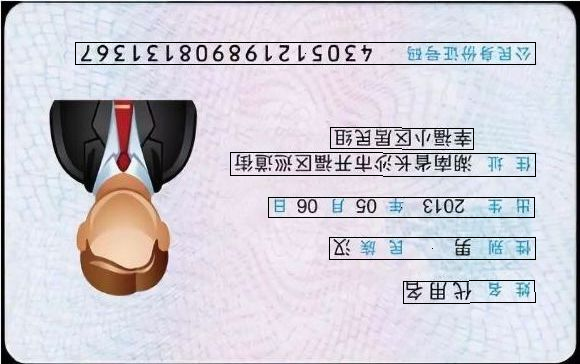

In [10]:
import time
from PIL import Image
p = './test/idcard-demo.jpeg'
img = cv2.imread(p)
b, g, r = cv2.split(img)
img = cv2.merge([r,g,b])

h,w = img.shape[:2]
timeTake = time.time()
_,result,angle= model.model(img,
                                    detectAngle=True,##是否进行文字方向检测
                                    config=dict(MAX_HORIZONTAL_GAP=50,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.1,
                                    TEXT_PROPOSALS_NMS_THRESH=0.3,
                                    TEXT_LINE_NMS_THRESH = 0.7,##文本行之间测iou值
                                                                                 
                ),
                                    leftAdjust=True,##对检测的文本行进行向左延伸
                                    rightAdjust=True,##对检测的文本行进行向右延伸
                                    alph=0.01,##对检测的文本行进行向右、左延伸的倍数
                                   
                                   )


        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
plot_boxes(img,angle, result,color=(0,0,0))